In [3]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.cosmology import WMAP9 as cosmo
from scipy.integrate import quad
#from astropy.cosmology import Planck15   # You can choose a different cosmology if needed
import astropy.units as u
from astropy import constants as const
from astropy.cosmology import FlatLambdaCDM

<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [4]:
def lx_func(func, fixed_value):
    def f(x):
        return func(fixed_value, x)
    return f

def z_func(func, fixed_value):
    def f(x):
        
        return func(x,fixed_value)
    return f

In [5]:
def simpsons_integration(func, a, b, n=3000):
    h = (b - a) / n
    s = func(a) + func(b)

    for i in range(1, n, 2):
        s += 4 * func(a + i * h)
    for i in range(2, n, 2):
        s += 2 * func(a + i * h)

    return s * h / 3

In [141]:
import pandas as pd
def Psi_Ueda(Lx):
     return 1/np.log(10)*1/Lx*((Lx/L_star)**(gamma1)+(Lx/L_star)**(gamma2))**(-1) 



def Psi_Ajello(Lx):
    return 1/Lx*(Lx/L_star)**(1-gamma2) #Function from Ajello et al 


def z_star(Lx): #Calc Z_star used for caculation of XLF for RG
    if (Lx < L_c):
        return z_c *(Lx/L_c)**alpha
    else:
        return z_c

def e_z(z,Lx): #Used in calculation of XLF for RG. redshift evolution is of type PDF
    z_s =z_star(Lx)
    if z<=z_s:
        return (1+z)**(v_1)
    else: 
        return e_z(z_s,Lx) *((1+z)/(1+z_s))**(v_2)

def e_z_PL(z): #Used in calculation of XLF for Blazars, BLlac, and FSRQ. redshift evolution is of type PLF
    
    return (1+z)**(v_1 + v_2*z)





H0 = 70.0  # Hubble constant in km/s/Mpc
Om0 = 0.3  # Matter density parameter (ΩM)
Ode0 = 0.7  # Dark energy density parameter (ΩΛ)

# Create a FlatLambdaCDM cosmology object
cosmo1 = FlatLambdaCDM(H0=H0, Om0=Om0)  # Replace with your desired H0 value



def integrandRG(z, lx): #different integrands, Blazar and FSRQ use the same integrand
   
    
    return Psi_Ueda(lx)*cosmo1.differential_comoving_volume(z).value*e_z(z,lx)

def integrandBlazar(z, lx):
   
    return Psi_Ueda(lx/e_z_PL(z))*cosmo1.differential_comoving_volume(z).value

def integrandBLlac(z, lx):
 
   
    return Psi_Ajello(lx/e_z_PL(z))*cosmo1.differential_comoving_volume(z).value



model_constants = { #Constants for all models, no unit attached yet
    'SLDDE_RG': {
        'A': 10**(-6.077),
        'L_star': 10**(44.33),
        'gamma1':2.15,
        'gamma2':1.10,
        'v1':4,
        'v2':-1.5,
        'z_c': 1.9,
        'Lc':10**(44.6),
        'alpha':   0.317,
        'corr_fac': 1,
        'L_lower':42,
         'L_higher':47,
        'integrand':integrandRG,
        
    },
    'AMPLE_Blazar': {
        'A': 1.379*10**(-7),
        'L_star': 1.81*10**(44),
        'gamma1':-0.87,
        'gamma2':2.73,
        'v1':3.45,
        'v2':-0.25,
        'z_c': 0,
        'Lc':0,
        'alpha':   0,
        'corr_fac': 1,
        'L_lower':44,
         'L_higher':48.5,
        'integrand':integrandBlazar,
        # Add more constants for model 1
    },
     'AMPLE_FSRQ': {
        'A': 0.175*10**(-7),
        'L_star': 2.42*10**(44),
        'gamma1':-50,
        'gamma2':2.49,
        'v1':3.67,
        'v2':-0.30,
        'z_c': 0,
        'Lc':0,
        'alpha':   0,
        'corr_fac': 1,
        'L_lower':46,
         'L_higher':48.5,
        'integrand':integrandBlazar,
        # Add more constants for model 1
    },
     'APLE_BLlac': {
        'A': 0.830*10**(-7),
        'L_star': 1*10**(44),
        'gamma1':0,
        'gamma2':2.61,
        'v1':-0.79,
        'v2':0,
        'z_c': 0,
        'Lc':0,
        'alpha':   0,
        'corr_fac': 1,
         'L_lower':44.5,
         'L_higher':48.5,
         'integrand':integrandBLlac,
        # Add more constants for model 1
    },}

    # Define the data for the table
data = {
'Model': ['RG\_SLDDE', 'AMPLE\_Blazar', 'AMPLE\_FSRQ', 'APLE\_BLlac'],
'A': [f"{model_constants[m]['A']:.3e}" if model_constants[m]['A'] != 0 else '' for m in model_constants],
'L\_star': [f"{model_constants[m]['L_star']:.3e}" if model_constants[m]['L_star'] != 0 else '' for m in model_constants],
r'$\gamma_1$': [f"{model_constants[m]['gamma1']:.2f}" if model_constants[m]['gamma1'] != 0 else '' for m in model_constants],
r'$\gamma_2$': [f"{model_constants[m]['gamma2']:.2f}" if model_constants[m]['gamma2'] != 0 else '' for m in model_constants],
r'$v_1$': [f"{model_constants[m]['v1']:.2f}" if model_constants[m]['v1'] != 0 else '' for m in model_constants],
r'$v_2$': [f"{model_constants[m]['v2']:.2f}" if model_constants[m]['v2'] != 0 else '' for m in model_constants],
r'$z_c$': [f"{model_constants[m]['z_c']:.2f}" if model_constants[m]['z_c'] != 0 else '' for m in model_constants],
r'$L_c$': [f"{model_constants[m]['Lc']:.3e}" if model_constants[m]['Lc'] != 0 else '' for m in model_constants],
r'$\alpha$': [f"{model_constants[m]['alpha']:.3f}" if model_constants[m]['alpha'] != 0 else '' for m in model_constants],
'corr\_fac': [f"{model_constants[m]['corr_fac']:.0f}" if model_constants[m]['corr_fac'] != 0 else '' for m in model_constants],
}

# Create a DataFrame from the data
df = pd.DataFrame(data)

# Print the DataFrame as a LaTeX table
print(df.to_latex(index=False))


selected_model = 'SLDDE_RG'
#different models 'SLDDE_RG', 'AMPLE_Blazar', 'AMPLE_FSRQ', 'APLE_BLlac'


# Access constants for the selected model and giving all constants their unit
constants = model_constants[selected_model]

A = constants['A']
L_star = constants['L_star']
gamma1 = constants['gamma1']
gamma2 = constants['gamma2']
v_1 = constants['v1']
v_2 = constants['v2']
z_c = constants['z_c']
L_c = constants['Lc']
alpha =constants['alpha']
corr_fac = constants['corr_fac']

N_steps = 50
L_x  = np.logspace(constants["L_lower"],constants["L_higher"],N_steps)


 
integrand = constants["integrand"]
# Define the limits of integration for 'z'
z_lower = 0.01
z_upper = 2.5

a = np.log10(L_x[-1])-np.log10(L_x[0])
x = L_x/(10.0**(44))# 

# Define the limits of integration for 'Lx', not used since it is not regular steps done in Jacobsen et al
L_x_lower = np.log10(L_x[0])
L_x_upper = np.log10(L_x[0])+a/3
Z_list = np.linspace(z_lower,9,N_steps)
print(integrand)

\begin{tabular}{lllllllllll}
\toprule
        Model &         A &   L\textbackslash \_star & \$\textbackslash gamma\_1\$ & \$\textbackslash gamma\_2\$ & \$v\_1\$ & \$v\_2\$ & \$z\_c\$ &     \$L\_c\$ & \$\textbackslash alpha\$ & corr\textbackslash \_fac \\
\midrule
    RG\textbackslash \_SLDDE & 8.375e-07 & 2.138e+44 &       2.15 &       1.10 &  4.00 & -1.50 &  1.90 & 3.981e+44 &    0.317 &         1 \\
AMPLE\textbackslash \_Blazar & 1.379e-07 & 1.810e+44 &      -0.87 &       2.73 &  3.45 & -0.25 &       &           &          &         1 \\
  AMPLE\textbackslash \_FSRQ & 1.750e-08 & 2.420e+44 &     -50.00 &       2.49 &  3.67 & -0.30 &       &           &          &         1 \\
  APLE\textbackslash \_BLlac & 8.300e-08 & 1.000e+44 &            &       2.61 & -0.79 &       &       &           &          &         1 \\
\bottomrule
\end{tabular}

<function integrandRG at 0x0000017F1ACA2A60>


C:\Users\henri\AppData\Local\Temp\ipykernel_1512\391667637.py:142: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(df.to_latex(index=False))


In [95]:
import numpy as np

def prefrom_int(func, list,z_lower,z_upper):

    results = []
    for h in list:
        results.append(A*corr_fac*4*np.pi*simpsons_integration(func(integrand,h), z_lower, z_upper))

    return results

integral_results_z_1 = prefrom_int(z_func, L_x,z_lower,z_upper)
integral_results_z_1  = np.array(integral_results_z_1)
print("done 1")
integral_results_z_2 =  prefrom_int(z_func, L_x,z_lower+ 2.5,z_upper+2.5)
integral_results_z_2 = np.array(integral_results_z_2)
print("done 2")
integral_results_z_3 = prefrom_int(z_func, L_x,z_lower+5,z_upper+5)
integral_results_z_3 = np.array(integral_results_z_3)
print("done 3")
integral_results_z_4 =  prefrom_int(z_func, L_x,z_lower+7.5,z_upper+7.5)
integral_results_z_4 = np.array(integral_results_z_4)

# Save the data in columns
data = np.column_stack((integral_results_z_1, integral_results_z_2, integral_results_z_3, integral_results_z_4, L_x, Z_list))
header = " "+str(z_lower)+ "<" + "z" + "<" + str(z_upper) + ", " + str(z_lower+2.5)+ "<" + "z" + "<" + str(z_upper+2.5) + ", " + str(z_lower+5)+ "<" + "z" + "<" + str(z_upper+5) + ", " + str(z_lower+7.5)+ "<" + "z" + "<" + str(z_upper+7.5) + ", " + "L_x" + ", " + "Z_list"
#header = "integral_results_z_1,integral_results_z_2,integral_results_z_3,integral_results_z_4,L_x,Z_list"
np.savetxt('lum_den_data/LD_' + selected_model + '.txt', data, delimiter=',', header=header)






done 1
done 2
done 3


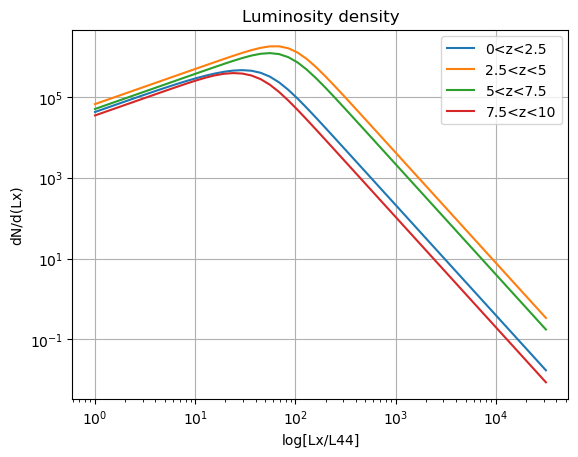

In [96]:
plt.figure(1)
plt.plot(x,L_x*integral_results_z_1,label = "0<z<2.5")
plt.plot(x,L_x*(integral_results_z_2),label = "2.5<z<5")
plt.plot(x,L_x*(integral_results_z_3),label = "5<z<7.5")
plt.plot(x,L_x*(integral_results_z_4),label = "7.5<z<10")
plt.ylabel("dN/d(Lx)")
plt.xlabel("log[Lx/L44]")
#plt.yticks(np.arange(min(integral_results_z_1), max(integral_results_z_4)+1, 1.0))
plt.yscale("log",base =10)
#plt.xlim(0.5)
#plt.ylim(1e1,5e8)
plt.xscale("log",base =10)
plt.title("Luminosity density")
plt.legend()
plt.grid()
plt.show()

In [97]:
 


if (selected_model == "AMPLE_Blazar"):
    a1 = 44
    a2 = 46.5
    a3 = 46.5
    a4 = 47.5
    a5 = 47.5
    a6 = 48.5

    print("AMPLE_Blazar")
elif(selected_model == "SLDDE_RG"):
    a1 = 42
    a2 = 43.5
    a3 = 43.5
    a4 = 45
    a5 = 45
    a6 = 47

    print("SLDDE_RG")

elif(selected_model == "AMPLE_FSRQ"):
    a1 = 46
    a2 = 46.75
    a3 = 46.75
    a4 = 47.5
    a5 = 47.5
    a6 = 48.5
    
    print("AMPLE_FSRQ")
else:
    a1 = 44.5
    a2 = 45.5
    a3 = 45.5
    a4 = 46.5
    a5 = 47.5
    a6 = 48.5
    print("APLE_BLlac")


integral_results_lx1 = prefrom_int(lx_func, Z_list,10**a1,10**a2)
print("done 1")
integral_results_lx2 =   prefrom_int(lx_func, Z_list,10**a3,10**a4)
print("done 2")
integral_results_lx3 =  prefrom_int(lx_func, Z_list,10**a5,10**a6)
print("done 3")
integral_results_lx4 =  prefrom_int(lx_func, Z_list,10**a1,10**a6)


# Save the data in columns
data = np.column_stack((integral_results_lx1, integral_results_lx2, integral_results_lx3, integral_results_lx4, L_x, Z_list))
header = str(a1) + "<" + "log(Lx)" + "<" + str(a2) + ", " + str(a3)+ "<" + "log(Lx)" + "<" + str(a4) + ", " + str(a5)+ "<" + "log(Lx)" + "<" + str(a6) + ", " + str(a1)+ "<" + "log(Lx)" + "<" + str(a6) + ", " + "L_x" + ", " + "Z_list"
#header = "integral_results_z_1,integral_results_z_2,integral_results_z_3,integral_results_z_4,L_x,Z_list"
np.savetxt('red_den_data/RD_' + selected_model + '.txt', data, delimiter=',', header=header)


AMPLE_Blazar
done 1
done 2
done 3


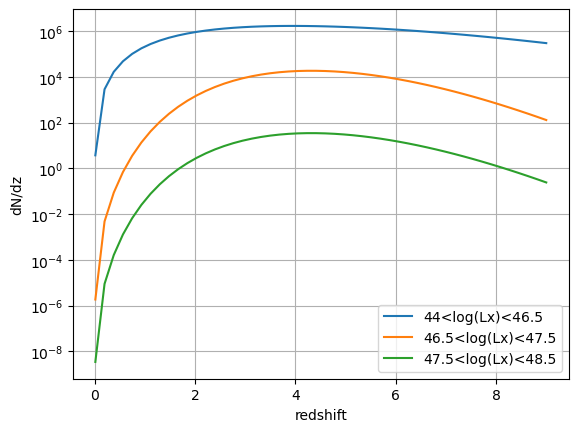

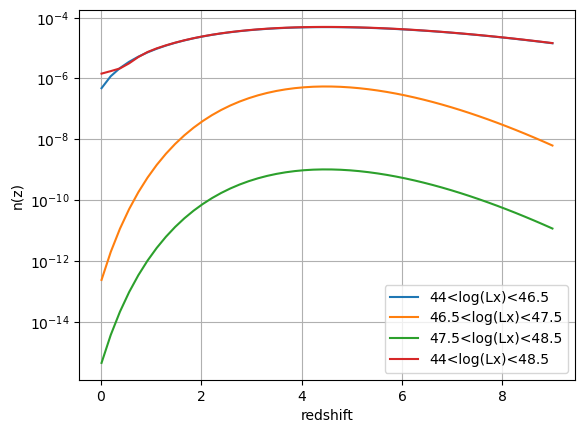

In [98]:

plt.figure(2)
plt.plot(Z_list,(integral_results_lx1),label = f"{a1}<log(Lx)<{a2}")
plt.plot(Z_list,(integral_results_lx2),label = f"{a3}<log(Lx)<{a4}")
plt.plot(Z_list,(integral_results_lx3),label = f"{a5}<log(Lx)<{a6}")
plt.ylabel("dN/dz")
plt.xlabel("redshift")
plt.yscale('log',base=10)
#plt.xscale('log',base=10)
plt.legend()
plt.grid()
plt.show()


n_z_1 =(integral_results_lx1)/cosmo1.differential_comoving_volume(Z_list).value

n_z_2 = (integral_results_lx2)/cosmo1.differential_comoving_volume(Z_list).value
n_z_3 = (integral_results_lx3)/cosmo1.differential_comoving_volume(Z_list).value

n_tot =(integral_results_lx4)/cosmo1.differential_comoving_volume(Z_list).value

plt.figure(2)
plt.plot(Z_list,(integral_results_lx1)/cosmo1.differential_comoving_volume(Z_list).value,label = f"{a1}<log(Lx)<{a2}")
plt.plot(Z_list,(integral_results_lx2)/cosmo1.differential_comoving_volume(Z_list).value,label = f"{a3}<log(Lx)<{a4}")
plt.plot(Z_list,(integral_results_lx3)/cosmo1.differential_comoving_volume(Z_list).value,label = f"{a5}<log(Lx)<{a6}")
plt.plot(Z_list,n_tot,label = f"{a1}<log(Lx)<{a6}")
plt.ylabel("n(z)")
plt.xlabel("redshift")
plt.yscale('log',base=10)
#plt.xscale('log',base=10)
#plt.ylim(10**(-1),10**(9))
#plt.xlim(10**(-2),10**(2))
plt.legend()
plt.grid()
plt.show()

[2.28546283e-13 1.09259938e-12 3.35460370e-12 9.99998649e-12
 6.23551015e-11 3.55862197e-10 1.70125428e-09 7.89651931e-09
 2.35393826e-08 4.24819978e-08 1.34339873e-15 1.34339873e-15
 4.00464754e-15 1.51177575e-14 1.65176749e-12 1.42510074e-13
 4.92388263e-11 1.15905157e-10 2.81007651e-10 1.91448111e-10
 6.61473766e-11 3.77504810e-11 8.88624217e-08 8.88624217e-08
 1.60371802e-07 1.60371802e-07 4.12462638e-07 4.12462638e-07
 6.42232542e-07 6.42232542e-07 8.13310925e-07 8.13310925e-07
 1.06081883e-06 1.06081883e-06 2.64896929e-07 2.64896929e-07]


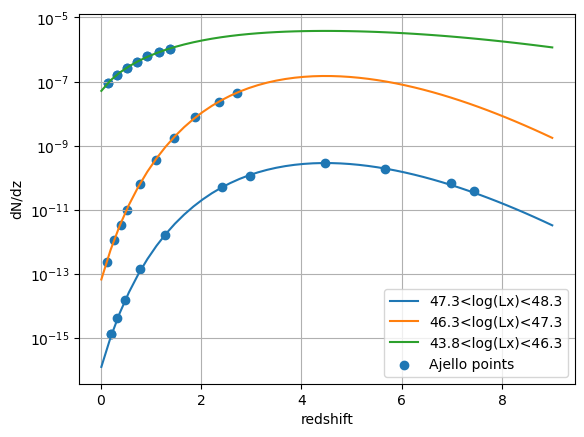

In [99]:
if (selected_model == "AMPLE_Blazar"):

    data = np.loadtxt('plot-data (1)_blazar_ajello.csv', delimiter=',', skiprows=1)
    data = np.loadtxt('plot-data (2).csv', delimiter=',', skiprows=1)
    #data2 = np.loadtxt('plot-data (1)new2.csv', delimiter=',', skiprows=1)

    print(data[:,1])

    integral_results_lx= prefrom_int(lx_func, Z_list,10**47.3, 10**48.3)

    integral_results_lx__2= prefrom_int(lx_func, Z_list,10**46.3, 10**47.3)
    integral_results_lx__3= prefrom_int(lx_func, Z_list,10**43.8, 10**46.3)
    plt.figure(2)
    plt.plot(Z_list,(integral_results_lx)/cosmo1.differential_comoving_volume(Z_list)/4/np.pi,label = f"{47.3}<log(Lx)<{48.3}")
    plt.plot(Z_list,(integral_results_lx__2)/cosmo1.differential_comoving_volume(Z_list)/4/np.pi,label = f"{46.3}<log(Lx)<{ 47.3}")
    plt.plot(Z_list,(integral_results_lx__3)/cosmo1.differential_comoving_volume(Z_list)/4/np.pi,label = f"{43.8}<log(Lx)<{ 46.3}")
    plt.scatter(data[:,0],data[:,1],label = "Ajello points")
    #plt.scatter(data2[:,0],data2[:,1])
    plt.plot()
    plt.ylabel("dN/dz")
    plt.xlabel("redshift")
    plt.yscale('log',base=10)
    #plt.xscale('log',base=10)
    #plt.ylim(10**(-1),10**(9))
    #plt.xlim(10**(-2),10**(2))
    plt.legend()
    plt.grid()
    plt.show()

In [100]:
##Emissivity j(z) of  my population j(z) = |<L(z)>| * n(z). Can start by setting |<L(z)>| = the average of my bin
n_1 = (integral_results_lx1)/cosmo1.differential_comoving_volume(Z_list).value
n_2 = (integral_results_lx2)/cosmo1.differential_comoving_volume(Z_list).value
n_3 = (integral_results_lx3)/cosmo1.differential_comoving_volume(Z_list).value

n_tot =(integral_results_lx4)/cosmo1.differential_comoving_volume(Z_list).value

def em_j_numerator(z,lx):
    return A*lx*integrand(z,lx)

def em_j_denominator(z,lx):
    return A*integrand(z,lx)

def em_j(z, lowerlim, upperlim):
    a = simpsons_integration(lx_func(em_j_numerator,z), lowerlim, upperlim,n=2000)
    b = simpsons_integration(lx_func(em_j_denominator,z), lowerlim, upperlim,n=2000)
    avg_lx = a/b

   
    return avg_lx 

#print(L_x)

em_j1 = []
em_j2 = []
em_j3 = []
em_tot = []
avg_lx1 = []
avg_lx2 = []
avg_lx3 = []
avg_tot = []
for z in Z_list:
    res1 = em_j(z,10**a1,10**a2)
    res2 = em_j(z,10**a3,10**a4)
    res3 = em_j(z,10**a5,10**a6)
    res = em_j(z,10**a1,10**a6)

    em_j1.append(res1 * n_1[Z_list == z])
    em_j2.append(res2 * n_2[Z_list == z])
    em_j3.append(res3 * n_3[Z_list == z])
    em_tot.append(res * (n_tot[Z_list == z]))
    avg_lx1.append(res1)
    avg_lx2.append(res2)
    avg_lx3.append(res3)
    avg_tot.append(res)
  




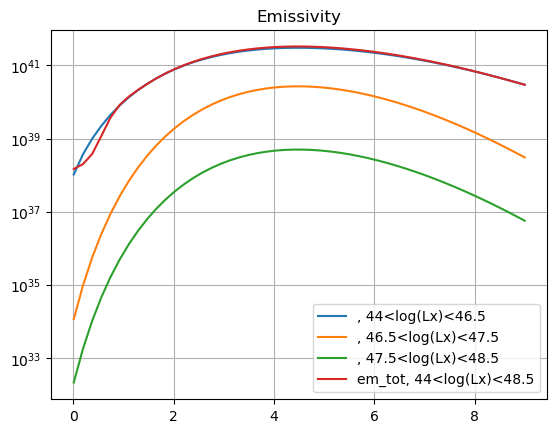

In [101]:
import numpy as np
plt.figure(1)
plt.plot(Z_list, em_j1,label = ", "+ f"{a1}<log(Lx)<{a2}")

plt.plot(Z_list, em_j2,label = ", "+ f"{a3}<log(Lx)<{a4}")

plt.plot(Z_list, em_j3,label = ", "+ f"{a5}<log(Lx)<{a6}")

plt.plot(Z_list, em_tot,label = "em_tot, "+ f"{a1}<log(Lx)<{a6}")

em_tot = np.reshape(em_tot, -1)

plt.legend()
plt.yscale('log',base=10)
plt.grid()
plt.title("Emissivity")
plt.show()

In [102]:
from scipy.optimize import curve_fit

def power_law(z,a, n):
    
    return a * (1 + z) ** n

# Fit the first array
#popt1, pcov1 = curve_fit(power_law, Z_list, avg_lx1, p0=[avg_lx1[0], 1])
#print(f"Fit parameters for array 1: a={popt1[0]:.2f}, n={popt1[1]:.2f}")

# Fit the second array
#popt2, pcov2 = curve_fit(power_law, Z_list, avg_lx2, p0=[avg_lx2[0], 1])
#print(f"Fit parameters for array 2: a={popt2[0]:.2f}, n={popt2[1]:.2f}")

# Fit the third array
#popt3, pcov3 = curve_fit(power_law, Z_list, avg_lx3, p0=[avg_lx3[0], 1])
#print(f"Fit parameters for array 3: a={popt3[0]:.2f}, n={popt3[1]:.2f}")
# Define the broken power law function
def broken_power_law(z, a, b, c, e):
    

    return a*((z/c)**b+(z/c)**e)**(-1)

# Fit the first array
popt1, pcov1 = curve_fit(broken_power_law, Z_list, avg_lx1, p0=[avg_lx1[0], 1, 1, -1])
print(f"Fit parameters for array 1: a={popt1[0]:.2f}, b={popt1[1]:.2f}, c={popt1[2]:.2f}, e={popt1[3]:.2f}")

# Fit the second array
popt2, pcov2 = curve_fit(broken_power_law, Z_list, avg_lx2, p0=[avg_lx2[0], 1, 1, -1])
print(f"Fit parameters for array 2: a={popt2[0]:.2f}, b={popt2[1]:.2f}, c={popt2[2]:.2f}, e={popt2[3]:.2f}")

# Fit the third array
popt3, pcov3 = curve_fit(broken_power_law, Z_list, avg_lx3, p0=[avg_lx3[0], 1, 1, -1])
print(f"Fit parameters for array 3: a={popt3[0]:.2f}, b={popt3[1]:.2f}, c={popt3[2]:.2f}, e={popt3[3]:.2f}")


# Define the broken power law function
def broken_power_law(z, a, b, c, e):
    return a*((z/c)**b+(z/c)**e)**(-1)

# Fit the first array
popt_tot, pcov_tot= curve_fit(broken_power_law, Z_list, avg_tot, p0=[avg_tot[0], 1, 1, -1])
print(f"Fit parameters for avg_tot: a={popt_tot[0]:.2f}, b={popt_tot[1]:.2f}, c={popt_tot[2]:.2f}, e={popt_tot[3]:.2f}")



popt_tot_em, pcov_tot_em= curve_fit(broken_power_law, Z_list, em_tot, p0=[em_tot[0], 1, 1, -1])
print(f"Fit parameters for em_tot: a={popt_tot_em[0]:.2f}, b={popt_tot_em[1]:.2f}, c={popt_tot_em[2]:.2f}, e={popt_tot_em[3]:.2f}")


popt_tot_n, pcov_tot_n= curve_fit(broken_power_law, Z_list, n_tot, p0=[n_tot[0], 1, 1, -1])
print(f"Fit parameters for n_tot: a={popt_tot_n[0]:.2f}, b={popt_tot_n[1]:.2f}, c={popt_tot_n[2]:.2f}, e={popt_tot_n[3]:.2f}")





Fit parameters for array 1: a=11456127198118282518915639458664974279237435392.00, b=-1.23, c=5.59, e=3.14
Fit parameters for array 2: a=98195781143015012419416678883650923475117277184.00, b=0.00, c=21.69, e=-0.00
Fit parameters for array 3: a=981279761782534582867243377849776008016540205056.00, b=-0.00, c=1.07, e=0.00
Fit parameters for avg_tot: a=12341509154091651658601118119882990843953414144.00, b=-1.33, c=5.47, e=3.22
Fit parameters for em_tot: a=17715422475215249724889604480624622567424.00, b=-0.26, c=0.00, e=-39.36
Fit parameters for n_tot: a=0.00, b=-1.36, c=5.45, e=3.26


C:\Users\henri\AppData\Local\Temp\ipykernel_1512\3842989386.py:22: RuntimeWarning: invalid value encountered in power
  return a*((z/c)**b+(z/c)**e)**(-1)
C:\Users\henri\AppData\Local\Temp\ipykernel_1512\3842989386.py:39: RuntimeWarning: overflow encountered in power
  return a*((z/c)**b+(z/c)**e)**(-1)
C:\Users\henri\AppData\Local\Temp\ipykernel_1512\3842989386.py:39: RuntimeWarning: invalid value encountered in power
  return a*((z/c)**b+(z/c)**e)**(-1)


1.0214451174438247e+44
2.861999452575701e+42


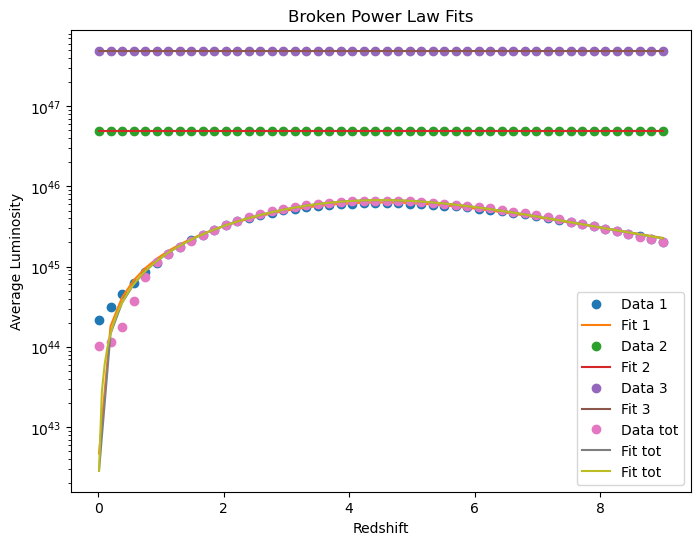

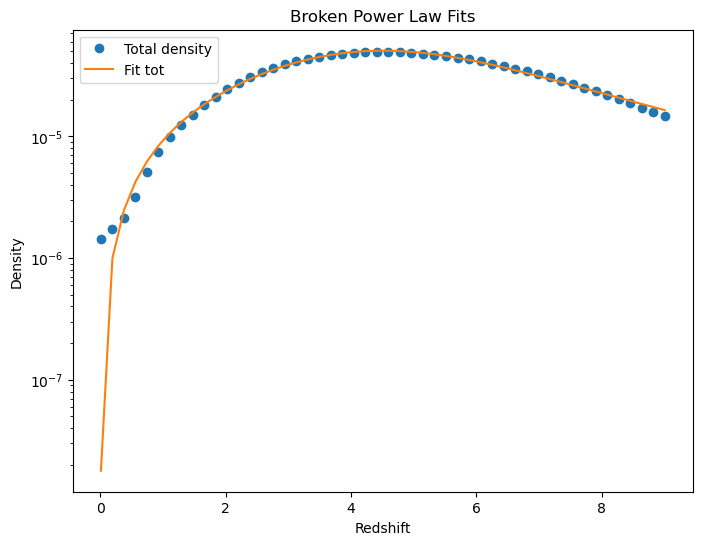

In [103]:
plt.figure(figsize=(8,6))

# Plot the first array and its fit
plt.plot(Z_list, avg_lx1, 'o', label='Data 1')
plt.plot(Z_list, broken_power_law(Z_list, *popt1), '-', label='Fit 1')

# Plot the second array and its fit
plt.plot(Z_list, avg_lx2, 'o', label='Data 2')
plt.plot(Z_list, broken_power_law(Z_list, *popt2), '-', label='Fit 2')

# Plot the third array and its fit
plt.plot(Z_list, avg_lx3, 'o', label='Data 3')
plt.plot(Z_list, broken_power_law(Z_list, *popt3), '-', label='Fit 3')

plt.plot(Z_list, avg_tot, 'o', label='Data tot')
plt.plot(Z_list, broken_power_law(Z_list, *popt_tot), '-', label='Fit tot')
z_tes_list = np.linspace(0.01,9,200)
plt.plot(z_tes_list, broken_power_law(z_tes_list, *popt_tot), '-', label='Fit tot')
print(avg_tot[0])
print(broken_power_law(Z_list[0], *popt_tot))

plt.xlabel('Redshift')
plt.ylabel('Average Luminosity')
plt.title('Broken Power Law Fits')
plt.yscale('log',base=10)

plt.legend()
plt.show()


plt.figure(figsize=(8,6))
plt.plot(Z_list, n_tot, 'o', label='Total density')
plt.plot(Z_list, broken_power_law(Z_list, *popt_tot_n), '-', label='Fit tot')
plt.xlabel('Redshift')
plt.ylabel('Density')
plt.title('Broken Power Law Fits')
plt.yscale('log',base=10)
plt.legend()
plt.show()



In [104]:


# Define the data to be written to file
data = np.hstack((np.array(Z_list).reshape(-1,1), L_x.reshape(-1,1), em_tot.reshape(-1,1), np.array(avg_tot).reshape(-1,1), (n_1+ n_2+ n_3).reshape(-1,1), (np.array(integral_results_z_1)+ np.array(integral_results_z_2)+np.array(integral_results_z_3)+ np.array(integral_results_z_4)).reshape(-1,1)))

# Define the filename based on the selected model
filename = selected_model + '.txt'

# Write the data to file
np.savetxt("model_data/"+filename, data, header='Z_list, L_x, em_tot, avg_tot, n_tot, integral_results_z_tot')


In [105]:
#Flux of neturinos, we treat them like photons that are not distrubed by their journey. 

def flux_nu(z):
    return ( broken_power_law(z, *popt_tot_em)/((cosmo1.luminosity_distance(z).value)**2)*cosmo.differential_comoving_volume(z).value)


flux_nu_tot = []

def get_flux(lowerlim, upperlim):
    a = simpsons_integration(flux_nu, lowerlim, upperlim,n=2000)
    return a


flux_tot = get_flux(0.001,10)

print(flux_tot * 624.151)



1.325473207742884e+47


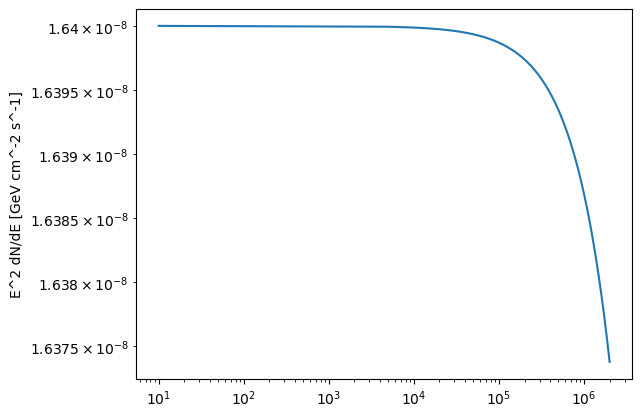

In [106]:
def ICECUBE(E_v, E_cut,gamma,phi_cut):
    return phi_cut*(E_v/100000)**(-gamma)*np.exp(-(E_v/E_cut))


E_cut = 1250000*10**3 #GeV
gamma = 2 #dimensionless
phi_cut = 1.64*10**(-18) #C units
E_v_list = np.linspace(0.01,2000,400)*(10**3) #GeV
plt.figure()
plt.plot(E_v_list,E_v_list**2*ICECUBE(E_v_list, E_cut,gamma,phi_cut))
plt.ylabel("E^2 dN/dE [GeV cm^-2 s^-1]")
plt.yscale('log',base=10)
plt.xscale('log',base=10)
plt.show()

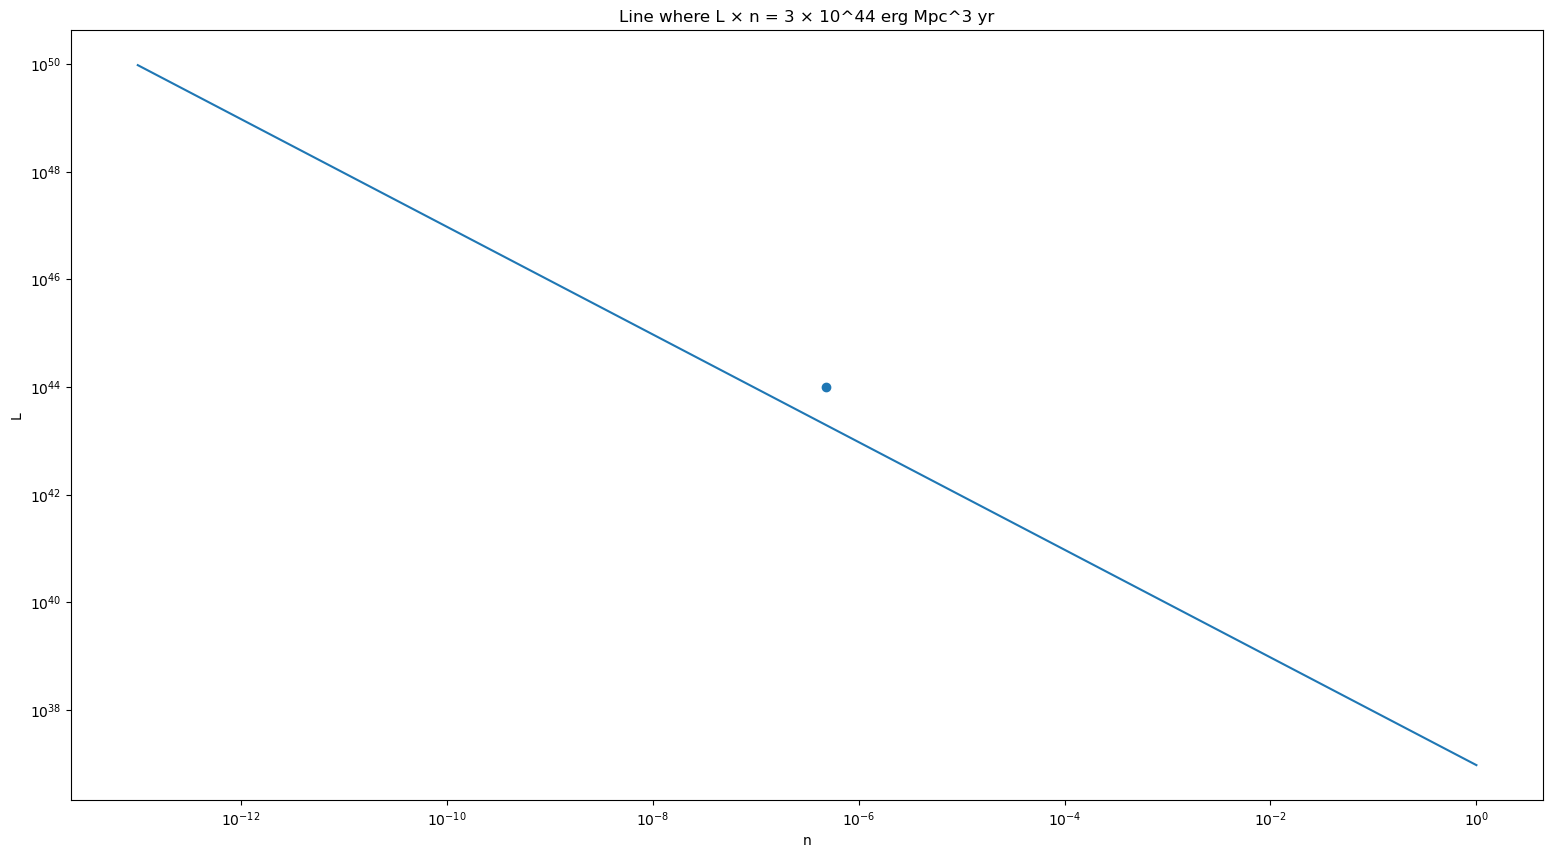

4.788092876942872e-07 1.0214451174438247e+44


In [107]:

diffuse_flux_UHECR = 6*10**(17) #ev, do not know where this comes from. I dont get it. This turns into 3*10^44 ergs/s/Mpc^3 ??


# Define the value of n
n_values = np.logspace(-13, 0, 1000)

# Calculate the corresponding values of L
L_values = (3 * 10**44) / n_values/(60*60*24*365)

# Plot the line
plt.figure(1, figsize=(19,10))
plt.plot(n_values, L_values)

n_z_tot = n_z_1 + n_z_2 + n_z_3
# Add labels and title
plt.xlabel('n')
plt.yscale('log',base=10)
plt.xscale('log',base=10)
plt.ylabel('L')
plt.scatter(n_z_tot[0], avg_tot[0], label='Blazars')
plt.title('Line where L × n = 3 × 10^44 erg Mpc^3 yr')

# Show the plot
plt.show()
print(n_z_tot[0], avg_tot[0])

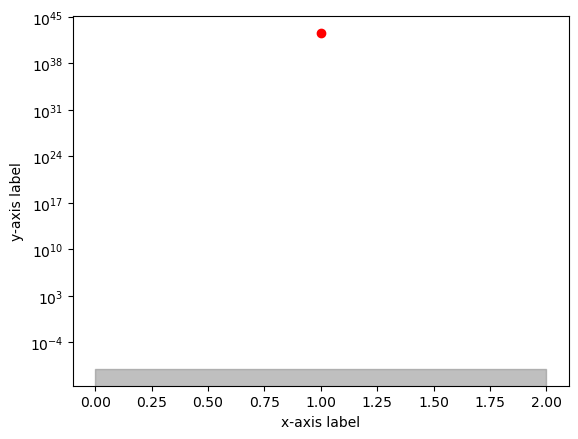

In [108]:
def flux_integrand(z):
    Dh = cosmo.hubble_distance.value  # Hubble distance in Mpc
    E_z = cosmo.efunc(z)  # E(z) function from astropy
    return (Dh / E_z) * (broken_power_law(z,*popt_tot) / (4 * np.pi * (1 + z)**2 )* broken_power_law(z, *popt_tot_n))

d_phi = []

for i in range(len(E_v_list)):
    Ev = E_v_list[i]



    results_flux = simpsons_integration(flux_integrand, 0.001, 9,n=20)

#print(results_flux/1e18)

# Plot the results_flux as a point
plt.plot(1, results_flux, 'ro')

# Grey out the area below 10^(-8)
plt.fill_between([0, 2], 0, 1e-8, color='gray', alpha=0.5)

# Set the y-axis scale to logarithmic
plt.yscale('log')

# Set the x-axis and y-axis labels
plt.xlabel('x-axis label')
plt.ylabel('y-axis label')

# Show the plot
plt.show()


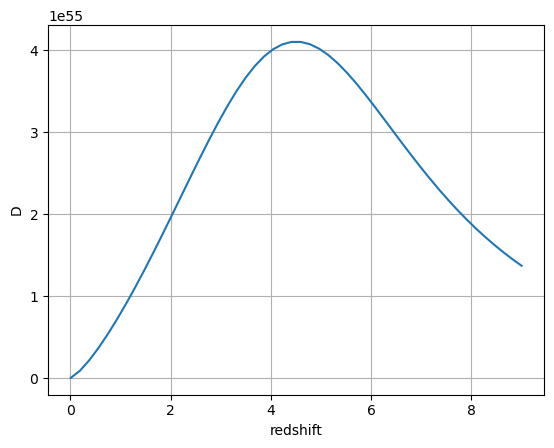

1.7863169583251237e+45
1.0214451174438247e+44
1.7863169583251237e+45


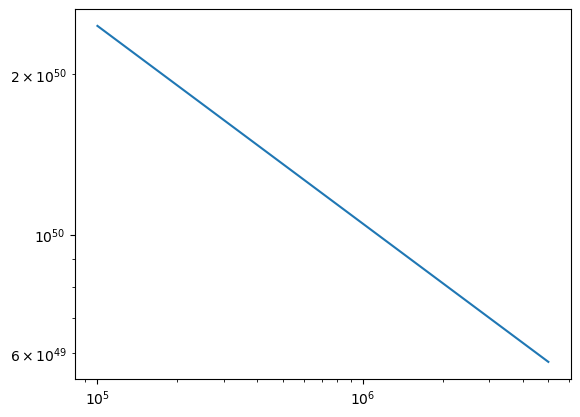

In [109]:
from scipy.optimize import minimize

def SED_neut(E_v,D): #general SED for all neutrino emmision from the tpye of AGN considered
    return D*E_v**(-2.37) #2.2 comes from some paper i think
E_v_list = np.linspace(100,5000,400)*(10**3) #GeV
E1 = E_v_list[0]
E2 = E_v_list[-1]

def integrate_SED(D,func): #Want this to equate the luminosity of our AGN, This luminosity is redshift dependent. 
    integral, _ = quad(func, E1, E2, args=(D))
    #print(integral)
    return integral


def objective_function(D, target_luminosity,func):
   
    return abs(integrate_SED(D,func) - target_luminosity)

#print(integrate_SED(2.829371152471951e+42))

#D_init = 2.829371152471951e+42
#z_trial = 0.01
#print(broken_power_law(z_trial, *popt_tot))
D_list = []

for i in range(len(Z_list)):
    z_trial = Z_list[i]
    D_init = broken_power_law(z_trial, *popt_tot)* 624.15 #conversion from ergs to GeV
    Neutrino_luminosity = broken_power_law(z_trial, *popt_tot)* 624.15
    result = minimize(objective_function, D_init, args=(Neutrino_luminosity,SED_neut),method='Nelder-Mead')
    D_list.append(result.x[0])

#result = minimize(objective_function, D_init, args=(broken_power_law(z_trial, *popt_tot)),method='Nelder-Mead')
D_list = np.array(D_list)

plt.figure()    
plt.plot(Z_list,D_list)
plt.ylabel("D")
plt.xlabel("redshift")

plt.grid()
plt.show()


# Optimal L0
#D_optimal = result.x[0]

print(integrate_SED(D_list[0],SED_neut))
print(avg_tot[0])#*624.15)
print(broken_power_law(Z_list[0], *popt_tot)* 624.15)
#print(D_optimal)
plt.figure()
plt.plot(E_v_list,E_v_list**2*SED_neut(E_v_list,D_list[0]))
plt.xscale('log',base=10)
plt.yscale('log',base=10)

Fit parameters for D_list: a=75062891058481917476329977864993099011125826315215699968.00, b=3.22, c=5.47478266, d=-1.33


C:\Users\henri\AppData\Local\Temp\ipykernel_1512\505856695.py:2: RuntimeWarning: overflow encountered in power
  return a*((z/c)**b+(z/c)**d)**(-1)
C:\Users\henri\AppData\Local\Temp\ipykernel_1512\505856695.py:2: RuntimeWarning: invalid value encountered in power
  return a*((z/c)**b+(z/c)**d)**(-1)


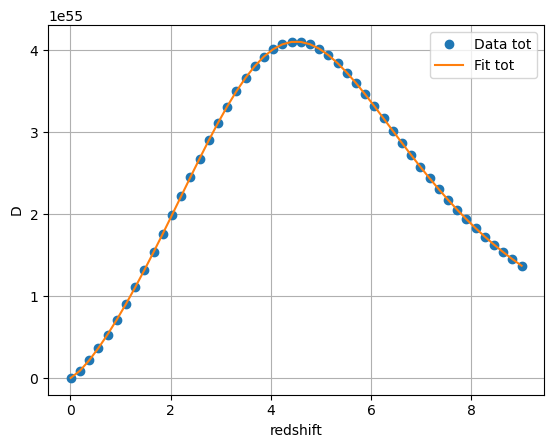

In [111]:
def D_func(z,a,b,c,d):
    return a*((z/c)**b+(z/c)**d)**(-1)

    

popt_tot_D, pcov_tot_D= curve_fit(D_func, Z_list, D_list, p0=[D_list[0], 1, 4, 1]) #c param very important and volatile
print(f"Fit parameters for D_list: a={popt_tot_D[0]:.2f}, b={popt_tot_D[1]:.2f}, c={popt_tot_D[2]:.8f}, d={popt_tot_D[3]:.2f}")


plt.figure()
plt.plot(Z_list, D_list, 'o', label='Data tot')
plt.plot(Z_list, D_func(Z_list, *popt_tot_D), '-', label='Fit tot')
plt.ylabel("D")
plt.xlabel("redshift")
plt.grid()
plt.legend()
plt.show()




In [112]:
def flux_integrand(z):
    Dh = cosmo.hubble_distance.value  # Hubble distance in Mpc
    E_z = cosmo.efunc(z)  # E(z) function from astropy
 
    return (Dh / E_z) * SED_neut(Ev*(1+z),(D_func(z,*popt_tot_D))) / (Ev**2 *4 * np.pi * (1 + z)**2 )* broken_power_law(z, *popt_tot_n)

d_phi = []

for i in range(len(E_v_list)):
    Ev = E_v_list[i]

    

    results_flux = simpsons_integration(flux_integrand, 0.001, 9,n=2000)
    d_phi.append(results_flux/(3.0857*10**24)**2) #convert from Mpc^2 to cm^2 

d_phi = np.array(d_phi)
#print(results_flux/1e18)

# Plot the results_flux as a point
#plt.plot(1, results_flux, 'ro')

# Grey out the area below 10^(-8)
#plt.fill_between([0, 2], 0, 1e-8, color='gray', alpha=0.5)

# Set the y-axis scale to logarithmic
#plt.yscale('log')

# Set the x-axis and y-axis labels
#plt.xlabel('x-axis label')
#plt.ylabel('y-axis label')

# Show the plot
#plt.show()

[2.36272408e-20 1.42422840e-20 9.04871986e-21 5.99974390e-21
 4.12121642e-21 2.91630754e-21 2.11670495e-21 1.57036098e-21
 1.18749921e-21 9.13196170e-22 7.12793722e-22 5.63816989e-22
 4.51334575e-22 3.65209806e-22 2.98425964e-22 2.46039884e-22
 2.04513145e-22 1.71275707e-22 1.44435804e-22 1.22583747e-22
 1.04657105e-22 8.98467341e-23 7.75303594e-23 6.72250679e-23
 5.85529152e-23 5.12157613e-23 4.49766702e-23 3.96460303e-23
 3.50711050e-23 3.11280988e-23 2.77160869e-23 2.47523346e-23
 2.21686634e-23 1.99086107e-23 1.79251962e-23 1.61791532e-23
 1.46375224e-23 1.32725257e-23 1.20606608e-23 1.09819689e-23
 1.00194403e-23 9.15852917e-24 8.38675638e-24 7.69338206e-24
 7.06913555e-24 6.50599132e-24 5.99698247e-24 5.53604492e-24
 5.11788687e-24 4.73787899e-24 4.39196184e-24 4.07656748e-24
 3.78855301e-24 3.52514395e-24 3.28388601e-24 3.06260375e-24
 2.85936513e-24 2.67245108e-24 2.50032922e-24 2.34163115e-24
 2.19513286e-24 2.05973760e-24 1.93446112e-24 1.81841874e-24
 1.71081403e-24 1.610928

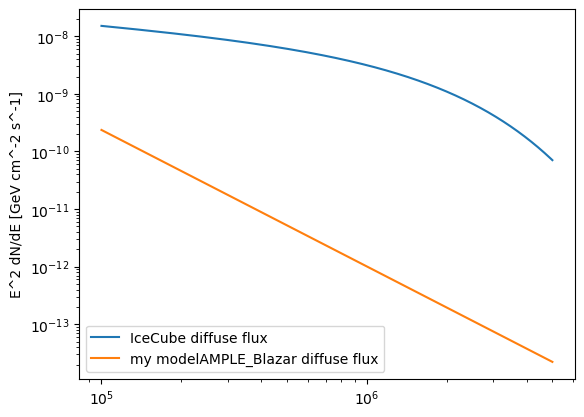

47812.81425499704


In [113]:
def ICECUBE(E_v, E_cut,gamma,phi_cut):
    return phi_cut*(E_v/100000)**(-gamma)*np.exp(-(E_v/E_cut))

print(d_phi)
E_cut = 1250000 #GeV
gamma = 2.37 #dimensionless
phi_cut = 1.64*10**(-18) #C units
#E_v_list = np.linspace(0.01,2000,400)*(10**3) #GeV
plt.figure()
plt.plot(E_v_list,E_v_list**2*ICECUBE(E_v_list, E_cut,gamma,phi_cut),label = "IceCube diffuse flux")
plt.plot(E_v_list,E_v_list**2*d_phi,label = "my model"+selected_model + " diffuse flux")
plt.ylabel("E^2 dN/dE [GeV cm^-2 s^-1]")
plt.yscale('log',base=10)
plt.xscale('log',base=10)
plt.legend()
plt.show()

print(cosmo.luminosity_distance(5).value)


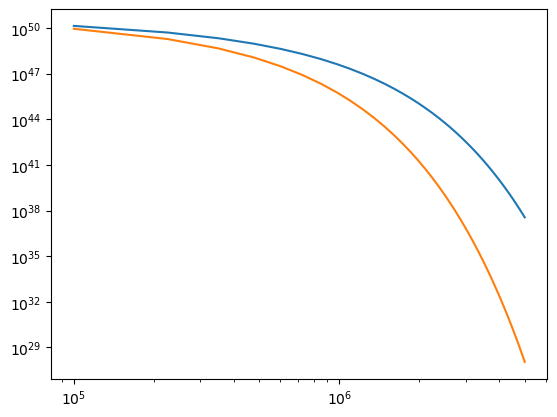

[ 100000.          225641.02564103  351282.05128205  476923.07692308
  602564.1025641   728205.12820513  853846.15384615  979487.17948718
 1105128.20512821 1230769.23076923 1356410.25641026 1482051.28205128
 1607692.30769231 1733333.33333333 1858974.35897436 1984615.38461538
 2110256.41025641 2235897.43589744 2361538.46153846 2487179.48717949
 2612820.51282051 2738461.53846154 2864102.56410256 2989743.58974359
 3115384.61538462 3241025.64102564 3366666.66666667 3492307.69230769
 3617948.71794872 3743589.74358974 3869230.76923077 3994871.79487179
 4120512.82051282 4246153.84615385 4371794.87179487 4497435.8974359
 4623076.92307692 4748717.94871795 4874358.97435897 5000000.        ]


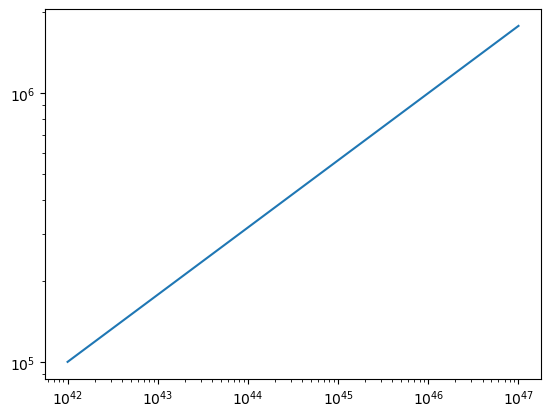

In [191]:
#Neut flux test 2

from scipy.optimize import minimize

def SED_neut_2(E_v,D,Lx): #general SED for all neutrino emmision from the tpye of AGN considered
    E_cut = func(Lx)
    return D*E_v**(-2.37)*np.exp(-E_v/E_cut) #2.2 comes from some paper i think

def func(Lx):
    below = 10**42
    return 100000*(Lx/below)**(0.25)


plt.figure()
plt.plot(E_v_list,E_v_list**2*SED_neut_2(E_v_list,D_list[0],10**43))
plt.plot(E_v_list,E_v_list**2*SED_neut_2(E_v_list,D_list[0],10**42))
plt.xscale('log',base=10)
plt.yscale('log',base=10)
plt.show()




print(E_v_list)
plt.figure()
plt.plot(L_x,func(L_x))
plt.xscale('log',base=10)
plt.yscale('log',base=10)
plt.show()




E_v_list = np.linspace(100,5000,10)*(10**3) #GeV
E1 = E_v_list[0]
E2 = E_v_list[-1]

c:\Users\henri\anaconda3\lib\site-packages\scipy\optimize\_minpack_py.py:881: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


2.0235896477251637e+42 2.991839389549095e+44


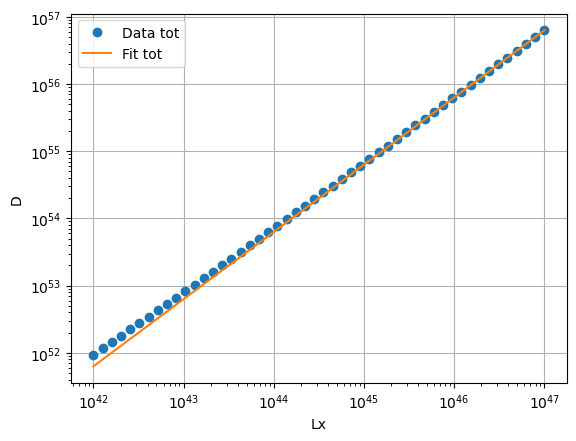

In [192]:
from scipy.integrate import dblquad
E_v_list = np.linspace(100,5000,40)*(10**3) #GeV
E1 = E_v_list[0]
E2 = E_v_list[-1]


def integrate_SED_2(D,lx,func): #Want this to equate the luminosity of our AGN, This luminosity is redshift dependent. 
    integral, _ = quad(func, E1, E2, args=(D,lx))
    #print(integral)
    return integral


def objective_function_2(D, target_luminosity,func):
   
    return abs(integrate_SED_2(D,target_luminosity,func) - target_luminosity)



D_list_2 = []
def lin_func(lx,a,b):
    return a*lx+b

for i in range(len(L_x)):
    lx = L_x[i]
    D_init =lx* 624.15 #conversion from ergs to GeV
    Neutrino_luminosity = lx* 624.15
    result = minimize(objective_function_2, D_init, args=(Neutrino_luminosity,SED_neut_2),method='Nelder-Mead')
    #print(lx, np.log10(result.x[0]))
    D_list_2.append(result.x[0])

popt_tot_D_2, pcov_tot_D_2= curve_fit(lin_func, L_x, D_list_2, p0=[ D_list_2[0],1]) 

lx = L_x[3]
print(lx, integrate_SED_2(lin_func(lx,*popt_tot_D_2),lx,SED_neut_2))

plt.figure()
plt.plot(L_x, D_list_2, 'o', label='Data tot')
plt.plot(L_x, lin_func(L_x, *popt_tot_D_2), '-', label='Fit tot')
plt.ylabel("D")
plt.xscale('log',base=10)
plt.yscale('log',base=10)
plt.xlabel("Lx")
plt.grid()
plt.legend()
plt.show()


In [193]:

lx = L_x[-5]
print(lx*624.15, integrate_SED_2(lin_func(lx,*popt_tot_D_2),lx*624.15,SED_neut_2))

2.4385165617126414e+49 2.4273563736785286e+49


In [194]:



def flux_integrand_2(z,lx):
    Dh = cosmo.hubble_distance.value  # Hubble distance in Mpc
    E_z = cosmo.efunc(z)  # E(z) function from astropy
    D = lin_func(lx, *popt_tot_D_2)
    
    return (Dh / E_z) * SED_neut_2(Ev*(1+z),D,lx*624.15) / (Ev**2 *4 * np.pi * (1 + z)**2 )* integrand(z,lx)/cosmo1.differential_comoving_volume(z).value



# Define the integration limits for z and lx
z_min = z_lower
z_max = 9
lx_min = L_x[0]  # Replace with the minimum value for lx
lx_max = L_x[-1]  # Replace with the maximum value for lx

# Perform the double integration
#result, error = dblquad(flux_integrand_2, lx_min, lx_max, lambda lx: z_min, lambda lx: z_max)

#print(result)


d_phi_2 = []
print("Start")
for i in range(len(E_v_list)):
    Ev = E_v_list[i]

    
    
    result, error = dblquad(flux_integrand_2, lx_min, lx_max,  z_min,  z_max,epsabs=1e-01, epsrel=1.49e-01)
    print(result)
    #print(i)
    d_phi_2.append(result/(3.0857*10**24)**2) #convert from Mpc^2 to cm^2 

print("End")
d_phi_2 = np.array(d_phi_2)


Start
1.1467754342547307e+35
2.7328250444313467e+33
3.328281013450522e+32
7.369394912239843e+31
2.2451407068173386e+31
8.369772803881649e+30
3.578255802172594e+30
1.709051758419532e+30
8.703616760564835e+29
4.8538215734392426e+29
2.7498395428386837e+29
1.6263132120606515e+29
9.97516320833932e+28
6.3133310087250544e+28
4.08244303080325e+28
2.717906465590808e+28
1.8275966128247234e+28
1.2656761313184423e+28
8.911724517942675e+27
6.370645232357305e+27
4.6173473962828914e+27
3.3901269524578496e+27
2.520435123012754e+27
1.877880981476891e+27
1.4638620941671244e+27
1.0831571733943129e+27
8.153405563443239e+26
6.384753364935132e+26
4.991746996808814e+26
3.995876289902912e+26
3.1473460580380753e+26
2.489171925623214e+26
1.9984117230276937e+26
1.612110060561787e+26
1.3067179624107585e+26
1.0641218697585027e+26
8.704624630939937e+25
7.15121069568211e+25
5.899317335489799e+25
4.885857886439151e+25
End


[1.20440065e-14 2.87014890e-16 3.49552640e-17 7.73970538e-18
 2.35795853e-18 8.79035204e-19 3.75806237e-19 1.79493123e-19
 9.14097158e-20 5.09772504e-20 2.88801837e-20 1.70803509e-20
 1.04764130e-20 6.63057450e-21 4.28758489e-21 2.85448067e-21
 1.91943294e-21 1.32927608e-21 9.35953671e-22 6.69076875e-22
 4.84936808e-22 3.56048008e-22 2.64708643e-22 1.97224409e-22
 1.53742084e-22 1.13758558e-22 8.56311239e-23 6.70558581e-23
 5.24258118e-23 4.19666819e-23 3.30549950e-23 2.61425227e-23
 2.09883147e-23 1.69311824e-23 1.37238025e-23 1.11759376e-23
 9.14203010e-24 7.51055746e-24 6.19575673e-24 5.13137117e-24]


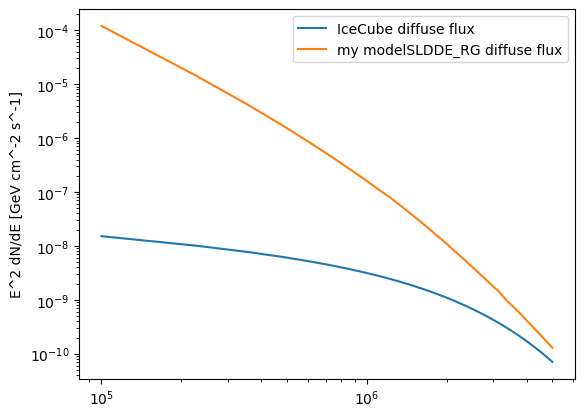

In [196]:
print(d_phi_2)
plt.figure()
plt.plot(E_v_list,E_v_list**2*ICECUBE(E_v_list, E_cut,gamma,phi_cut),label = "IceCube diffuse flux")
plt.plot(E_v_list,E_v_list**2*abs(d_phi_2),label = "my model"+selected_model + " diffuse flux")
plt.ylabel("E^2 dN/dE [GeV cm^-2 s^-1]")
plt.yscale('log',base=10)
plt.xscale('log',base=10)
plt.legend()
plt.show()

[3.26186884e-16 7.29076762e-18 8.31484320e-19 1.73749401e-19
 5.00974733e-20 1.76721861e-20 7.16634116e-21 3.22092858e-21
 1.56793284e-21 8.13300877e-22 4.44646236e-22 2.54101771e-22
 1.50825618e-22 9.25546261e-23 5.84389676e-23 3.78614189e-23
 2.51013319e-23 1.69906742e-23 1.17201855e-23 8.26492432e-24
 5.85471593e-24 4.22927581e-24 3.09698824e-24 2.29661985e-24
 1.72005445e-24 1.30237500e-24 9.95607441e-25 7.69001816e-25
 5.97241260e-25 4.68094062e-25 3.69556426e-25 2.93752756e-25
 2.35625513e-25 1.89119683e-25 1.53065309e-25 1.24544347e-25
 1.01850238e-25 8.36895815e-26 6.90776323e-26 5.72612545e-26]


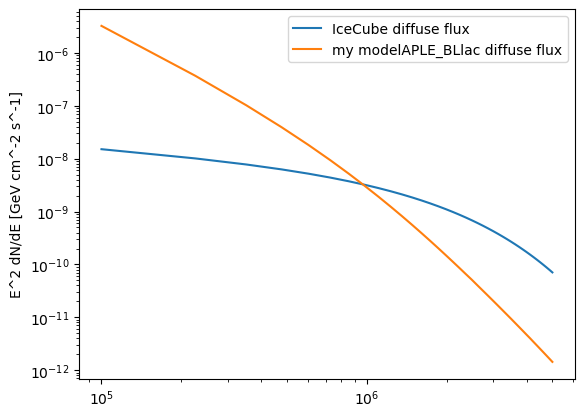

In [140]:
print(d_phi_2)
plt.figure()
plt.plot(E_v_list,E_v_list**2*ICECUBE(E_v_list, E_cut,gamma,phi_cut),label = "IceCube diffuse flux")
plt.plot(E_v_list,E_v_list**2*d_phi_2,label = "my model"+selected_model + " diffuse flux")
plt.ylabel("E^2 dN/dE [GeV cm^-2 s^-1]")
plt.yscale('log',base=10)
plt.xscale('log',base=10)
plt.legend()
plt.show()

[5.96013733e-15 1.18122161e-16 1.19946946e-17 2.24112304e-18
 5.79578585e-19 1.83882191e-19 6.72250795e-20 2.72954219e-20
 1.20222576e-20 5.63973222e-21 2.80004872e-21 1.45681273e-21
 7.86685653e-22 4.39487140e-22 2.52987712e-22 1.49550661e-22
 9.05408417e-23 5.60105601e-23 3.53440474e-23 2.27001961e-23
 1.48219202e-23 9.82620611e-24 6.60670218e-24 4.50056733e-24
 3.10346238e-24 2.16458855e-24 1.52595315e-24 1.08656016e-24
 7.81039144e-25 5.66439976e-25 4.14269445e-25 3.05395979e-25
 2.26837223e-25 1.69695034e-25 1.27812554e-25 9.68912433e-26
 7.39042539e-26 5.67028282e-26 4.37497161e-26 3.39370016e-26]


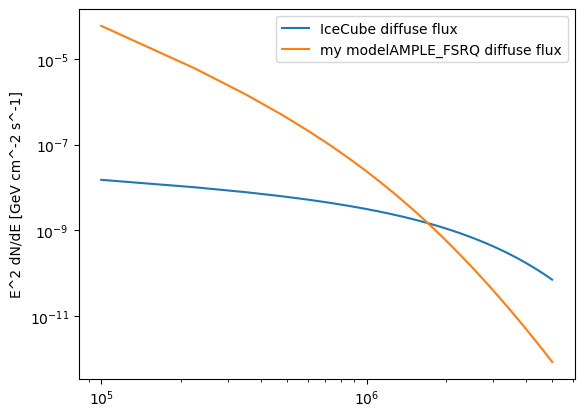

In [136]:
print(d_phi_2)
plt.figure()
plt.plot(E_v_list,E_v_list**2*ICECUBE(E_v_list, E_cut,gamma,phi_cut),label = "IceCube diffuse flux")
plt.plot(E_v_list,E_v_list**2*d_phi_2,label = "my model"+selected_model + " diffuse flux")
plt.ylabel("E^2 dN/dE [GeV cm^-2 s^-1]")
plt.yscale('log',base=10)
plt.xscale('log',base=10)
plt.legend()
plt.show()

[9.74392095e-15 1.80248208e-16 1.71324510e-17 3.00006261e-18
 7.17106022e-19 2.12913604e-19 7.42841822e-20 2.82841468e-20
 1.16815095e-20 5.15002497e-21 2.39620283e-21 1.16724672e-21
 5.91567820e-22 3.10590089e-22 1.68415687e-22 9.41922474e-23
 5.44184310e-23 2.84356880e-23 1.67808942e-23 1.00917430e-23
 6.17673837e-24 3.83970960e-24 2.42254137e-24 1.55367398e-24
 1.01021940e-24 6.71223203e-25 4.47138158e-25 3.01469116e-25
 2.05592900e-25 1.39844381e-25 9.76300357e-26 6.94562334e-26
 4.91561206e-26 3.52273460e-26 2.53851037e-26 1.85093262e-26
 1.36002091e-26 1.00671812e-26 7.50477518e-27 5.63284229e-27]


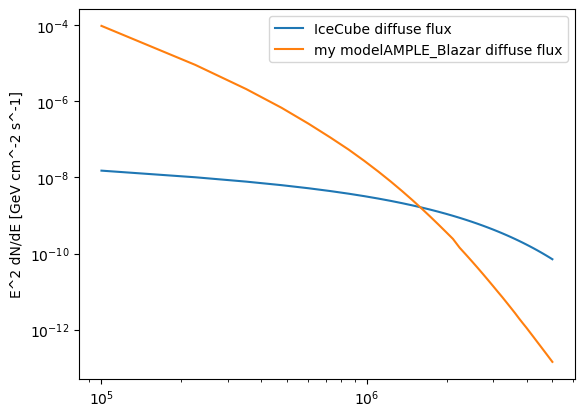

In [128]:
print(d_phi_2)
plt.figure()
plt.plot(E_v_list,E_v_list**2*ICECUBE(E_v_list, E_cut,gamma,phi_cut),label = "IceCube diffuse flux")
plt.plot(E_v_list,E_v_list**2*d_phi_2,label = "my model"+selected_model + " diffuse flux")
plt.ylabel("E^2 dN/dE [GeV cm^-2 s^-1]")
plt.yscale('log',base=10)
plt.xscale('log',base=10)
plt.legend()
plt.show()